Epoch 1/100
252/252 [==============================] - 7s 19ms/step - loss: 0.6285 - accuracy: 0.6944 - val_loss: 0.6572 - val_accuracy: 0.6667
Epoch 2/100
252/252 [==============================] - 4s 18ms/step - loss: 0.6198 - accuracy: 0.6984 - val_loss: 0.6764 - val_accuracy: 0.6667
Epoch 3/100
252/252 [==============================] - 4s 17ms/step - loss: 0.5839 - accuracy: 0.7163 - val_loss: 0.7249 - val_accuracy: 0.6667
Epoch 4/100
252/252 [==============================] - 4s 18ms/step - loss: 0.5464 - accuracy: 0.7440 - val_loss: 0.5113 - val_accuracy: 0.8380
Epoch 5/100
252/252 [==============================] - 4s 18ms/step - loss: 0.5181 - accuracy: 0.7560 - val_loss: 0.4777 - val_accuracy: 0.7315
Epoch 6/100
252/252 [==============================] - 4s 17ms/step - loss: 0.4784 - accuracy: 0.7639 - val_loss: 0.4325 - val_accuracy: 0.8380
Epoch 7/100
252/252 [==============================] - 4s 17ms/step - loss: 0.4529 - accuracy: 0.7976 - val_loss: 0.4317 - val_accuracy:

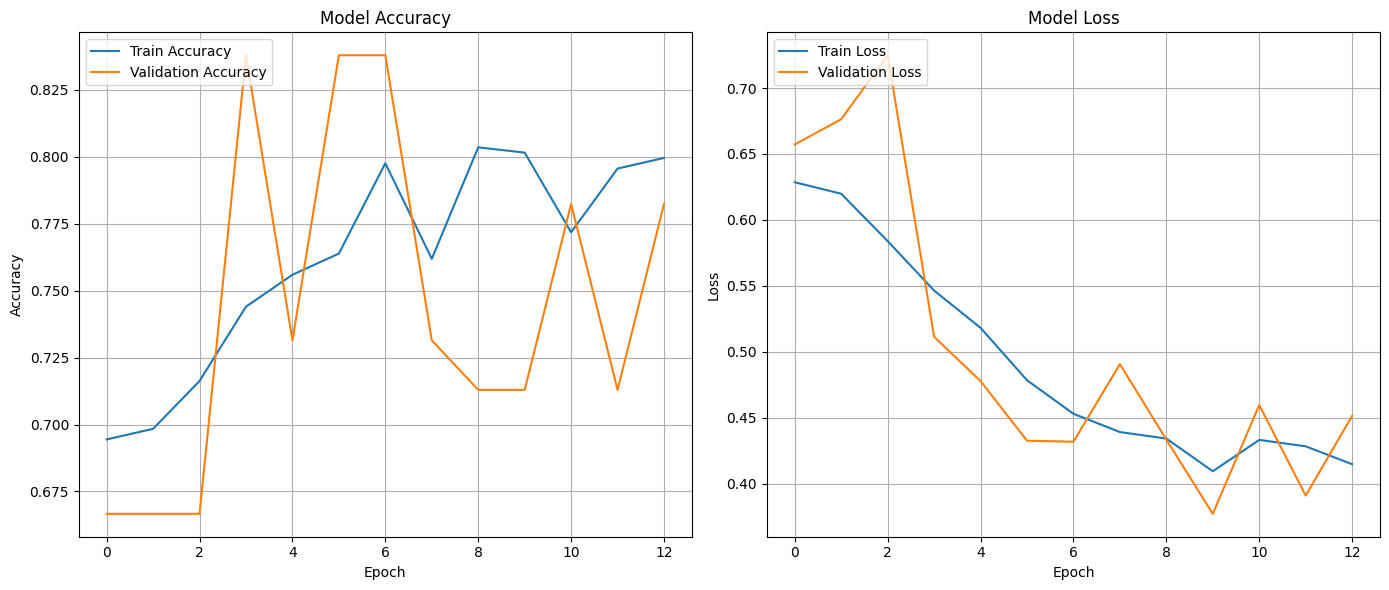

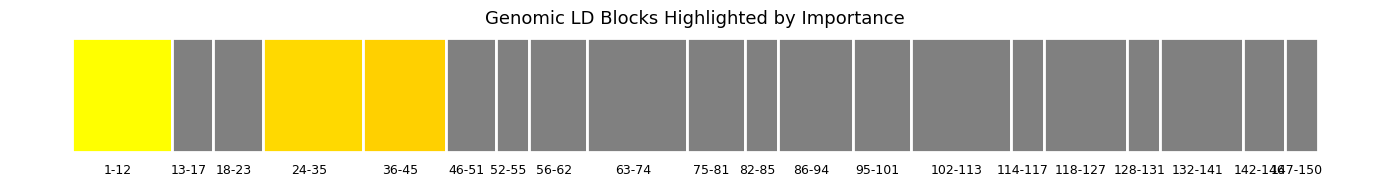

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def load_samples(file_path):
    with open(file_path, 'r') as file:
        samples = file.read().splitlines()
    return samples

def load_ld_blocks(file_path):
    ld_blocks = []
    with open(file_path, 'r') as file:
        for line in file:
            start, end = map(int, line.strip().split('-'))
            ld_blocks.append((start, end))
    return ld_blocks

def load_labels(file_path):
    with open(file_path, 'r') as file:
        labels = list(map(int, file.read().split()))
    return np.array(labels)

def tokenize_genomes(genomes, ld_blocks):
    tokenized_data = []
    for genome in genomes:
        tokenized_genome = []
        for start, end in ld_blocks:
            block = genome[start-1:end]
            tokenized_genome.append(list(map(int, block)))
        tokenized_data.append(tokenized_genome)
    return tokenized_data

def preprocess_genomes(genomes, ld_blocks):
    tokenized_data = tokenize_genomes(genomes, ld_blocks)
    max_block_length = max(end - start + 1 for start, end in ld_blocks)
    padded_data = []
    for genome in tokenized_data:
        padded_genome = pad_sequences(genome, maxlen=max_block_length, padding='post')
        padded_data.append(padded_genome)
    return np.array(padded_data)

samples_file_path = 'example/shuffled_sample.raw'
ld_blocks_file_path = 'example/ld.block'
labels_file_path = 'example/label.txt'

genomes = load_samples(samples_file_path)
ld_blocks = load_ld_blocks(ld_blocks_file_path)
labels = load_labels(labels_file_path)

tokenized_data = preprocess_genomes(genomes, ld_blocks)

assert len(tokenized_data) == len(labels), f"Data and labels must have the same number of samples. Found {len(tokenized_data)} data samples and {len(labels)} labels."

X_train, X_val, y_train, y_val = train_test_split(tokenized_data, labels, test_size=0.3, random_state=42, shuffle=True)

vocab_size = 10
model_dim = 32
num_heads = 2
num_layers = 2
num_classes = 2
input_shape = (X_train.shape[1], X_train.shape[2])

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, model_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)
        self.ln1 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            Dense(model_dim, activation='relu'),
            Dense(model_dim)
        ])
        self.ln2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output, attn_weights = self.att(inputs, inputs, return_attention_scores=True)
        out1 = self.ln1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.ln2(out1 + ffn_output), attn_weights

inputs = Input(shape=input_shape)
x = Embedding(input_dim=vocab_size, output_dim=model_dim)(inputs)
attn_weights_list = []

for _ in range(num_layers):
    transformer_block = TransformerBlock(model_dim, num_heads)
    x, attn_weights = transformer_block(x)
    attn_weights_list.append(attn_weights)

x = Reshape((-1, model_dim))(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_val, y_val), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Loss: {loss}, Accuracy: {accuracy}")

predictions = model.predict(tokenized_data)

extract_model = Model(inputs=model.inputs, outputs=attn_weights_list[-1])
attention_weights = extract_model.predict(tokenized_data)

def plot_attention_weights(attn_weights):
    avg_weights = np.mean(attn_weights, axis=(0, 1))

    if avg_weights.ndim == 2:
        plt.figure(figsize=(10, 8))
        plt.imshow(avg_weights, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title('Attention Weights')
        plt.xlabel('LD Block Index')
        plt.ylabel('LD Block Index')
        plt.show()
    else:
        print(f"Invalid shape for average attention weights: {avg_weights.shape}")

plot_attention_weights(attention_weights)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

def calculate_feature_importance(attn_weights):
    avg_weights = np.mean(attn_weights, axis=(0, 1))
    feature_importance = np.sum(avg_weights, axis=0)
    return feature_importance

feature_importance = calculate_feature_importance(attention_weights)
feature_importance = np.mean(feature_importance, axis=(0, -1))
norm = (feature_importance - feature_importance.min()) / (feature_importance.max() - feature_importance.min())

def custom_colormap(val, threshold=0.85):
    if val >= threshold:
        return plt.cm.autumn(val)
    else:
        return 'gray'

ld_blocks = load_ld_blocks(ld_blocks_file_path)

fig, ax = plt.subplots(figsize=(14, 2))

for i, (start, end) in enumerate(ld_blocks):
    color = custom_colormap(norm[i])
    ax.fill_betweenx([0, 1], start-1, end, color=color, edgecolor='white', linewidth=2)
    ax.text((start + end - 2) / 2, -0.1, f'{start}-{end}', ha='center', va='center', fontsize=9, color='black', transform=ax.get_xaxis_transform())

ax.set_yticks([])
ax.set_title('Genomic LD Blocks Highlighted by Importance', fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(left=False, bottom=False, labelbottom=False)

plt.tight_layout()
plt.show()


538/538 [==============================] - 2s 4ms/step - loss: 0.6190 - accuracy: 0.6705 - val_loss: 0.6285 - val_accuracy: 0.6695


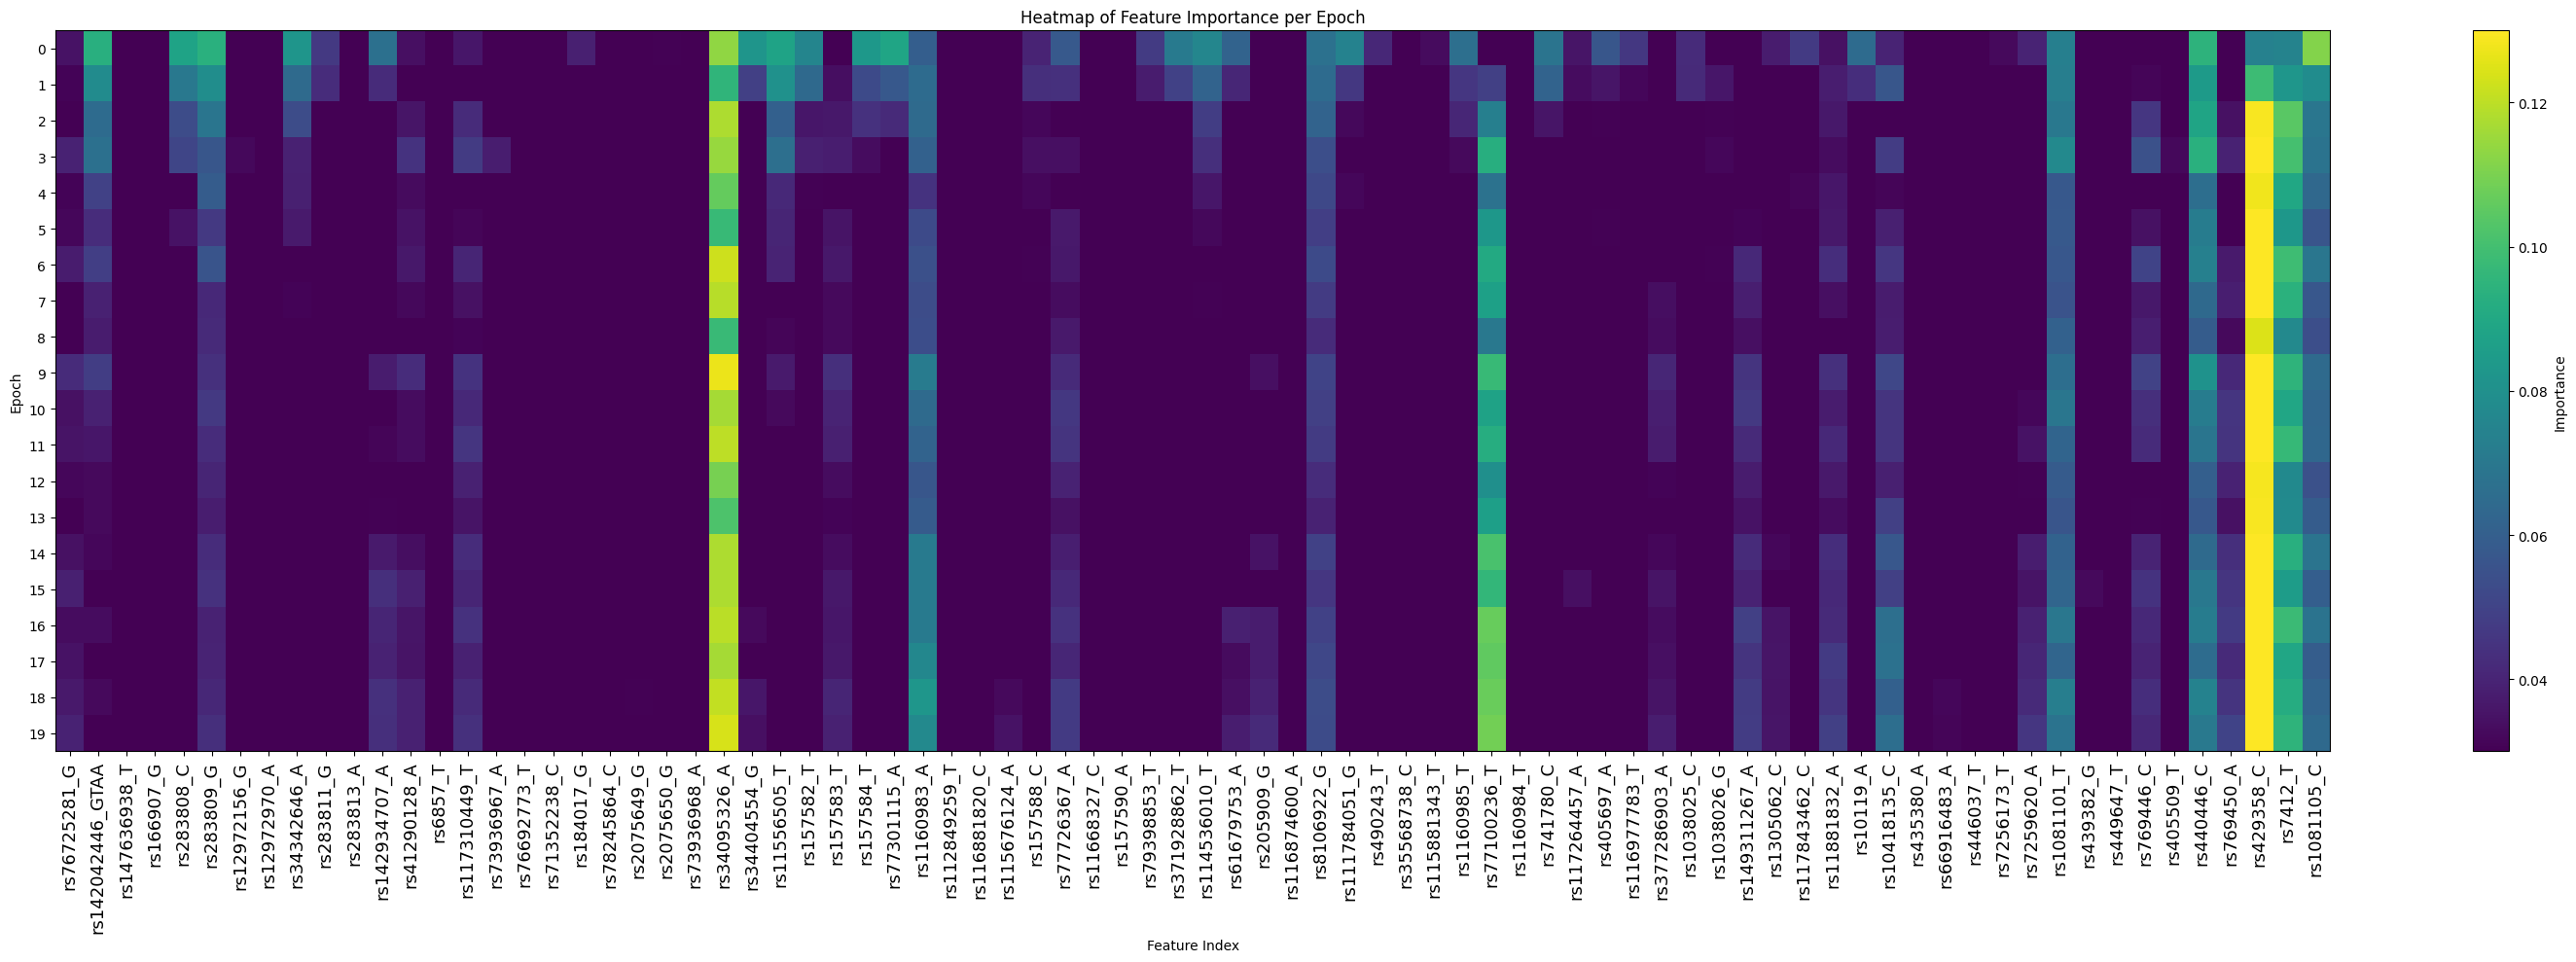

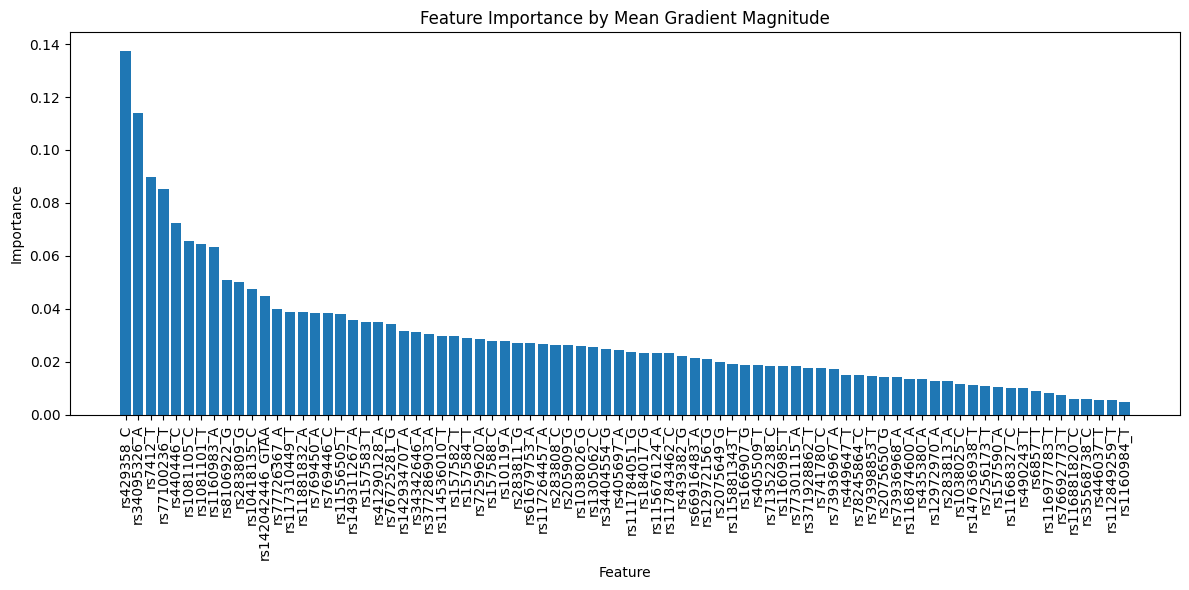

Feature importance in descending order:
rs429358_C: 0.1375
rs34095326_A: 0.1138
rs7412_T: 0.0897
rs77100236_T: 0.0851
rs440446_C: 0.0726
rs1081105_C: 0.0657
rs1081101_T: 0.0646
rs1160983_A: 0.0635
rs8106922_G: 0.0511
rs283809_G: 0.0503
rs10418135_C: 0.0477
rs142042446_GTAA: 0.0449
rs77726367_A: 0.0400
rs117310449_T: 0.0390
rs11881832_A: 0.0389
rs769450_A: 0.0385
rs769446_C: 0.0384
rs11556505_T: 0.0380
rs149311267_A: 0.0356
rs157583_T: 0.0352
rs41290128_A: 0.0349
rs76725281_G: 0.0342
rs142934707_A: 0.0315
rs34342646_A: 0.0312
rs377286903_A: 0.0306
rs114536010_T: 0.0299
rs157582_T: 0.0296
rs157584_T: 0.0290
rs7259620_A: 0.0287
rs157588_C: 0.0279
rs10119_A: 0.0279
rs283811_G: 0.0272
rs61679753_A: 0.0271
rs117264457_A: 0.0268
rs283808_C: 0.0265
rs205909_G: 0.0263
rs1038026_G: 0.0260
rs1305062_C: 0.0255
rs34404554_G: 0.0249
rs405697_A: 0.0244
rs111784051_G: 0.0238
rs184017_G: 0.0233
rs115676124_A: 0.0232
rs117843462_C: 0.0232
rs439382_G: 0.0224
rs66916483_A: 0.0214
rs12972156_G: 0.0212
rs20

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention

genomic_data = pd.read_csv("example/19_44883203_44909698.raw", delim_whitespace=True)
labels = pd.read_csv("example/19_44883203_44909698.label", header=None)
labels = labels.iloc[:len(genomic_data)]
genomic_data.fillna(genomic_data.mean(), inplace=True)
scaler = StandardScaler()
X = scaler.fit_transform(genomic_data.values)
y = labels.values.flatten()
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train_tensor = tf.expand_dims(x_train, axis=1)
x_test_tensor = tf.expand_dims(x_test, axis=1)
y_train_tensor = y_train.reshape(-1, 1)
y_test_tensor = y_test.reshape(-1, 1)

class Transformer(tf.keras.Model):
    def __init__(self, num_features):
        super(Transformer, self).__init__()
        self.d_model = num_features
        self.num_heads = max(1, num_features // 64)
        self.dropout = Dropout(0.1)
        self.mha = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.d_model)
        self.layer_norm = LayerNormalization()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, x, training=False):
        attn_output = self.mha(x, x)
        attn_output = self.dropout(attn_output, training=training)
        attn_output = self.layer_norm(attn_output + x)
        output = tf.reduce_mean(attn_output, axis=1)
        return self.dense(output)

model = Transformer(num_features=x_train.shape[1])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model(x_train_tensor[:1])

feature_importances = []

for epoch in range(20):
    history = model.fit(x_train_tensor, y_train_tensor, validation_split=0.2, epochs=1, batch_size=32)
    with tf.GradientTape() as tape:
        tape.watch(x_train_tensor)
        predictions = model(x_train_tensor)
        loss = tf.keras.losses.binary_crossentropy(y_train_tensor, predictions)
    gradients = tape.gradient(loss, x_train_tensor)
    feature_importance = tf.reduce_mean(tf.abs(gradients), axis=0).numpy().flatten()
    feature_importances.append(feature_importance)

mean_importances = np.mean(feature_importances, axis=0)
sorted_indices = np.argsort(-mean_importances)

sorted_features = genomic_data.columns[sorted_indices]

feature_importances = np.array(feature_importances)

max_importance = 0.13
min_importance = 0.03

plt.figure(figsize=(30, 10))
plt.imshow(feature_importances, aspect='auto', cmap='viridis', interpolation='nearest', vmin=min_importance, vmax=max_importance)
plt.colorbar(label='Importance')
plt.title('Heatmap of Feature Importance per Epoch')
plt.xlabel('Feature Index')
plt.ylabel('Epoch')

plt.xticks(ticks=np.arange(len(genomic_data.columns)), labels=genomic_data.columns, rotation=90, fontsize=13)
plt.yticks(ticks=np.arange(feature_importances.shape[0]), fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(range(len(mean_importances)), mean_importances[sorted_indices], tick_label=sorted_features)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance by Mean Gradient Magnitude')
plt.tight_layout()
plt.show()

sorted_importances = mean_importances[sorted_indices]

print("Feature importance in descending order:")
for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance:.4f}")
